# Non Comopliance and LATE

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline


- 실험의 subject들은 4가지로 나눌 수 있을 것이다. 예를 들어, 약 실험을 한다고 하면
  - Compilers: 가장 정상적인 집단, treatment가 할당되면 treatment를 받고 placebo가 할당되면 placebo 섭취
  - Never Takers: 둘 다 섭취 안함
  - Always Takers: treatment를 할당받던 placebo를 할당받던 treatment 섭취
  - Defiers: 할당된 것의 반대로 섭취

- 만약에 마케팅 push에 대한 실험을 한다고 하자.
- 그래서 treat, control 그룹을 나누어서 push를 보냈는데 push를 받아야할 사람들중에 받지 못하는 사람이 존재했다.
- 알고보니 옛날 핸드폰을 사용하는 유저들은 push를 받지 못하는 것이다.
- 그렇다면 push assigned라는 treatment로 인한 app purchase라는 outcome에 대한 causality는 어떻게 해석해야할까?

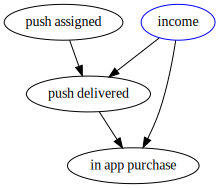

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

- Never Taker가 control 그룹에 존재하기 때문에 `push assigned`의 causal effect는 biased towards zero가 된다.
- 그렇다면 `assigned`가 아니라 `delivered`를 treatment라고 하자.

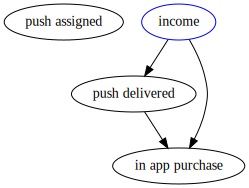

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

- `delivered`도 biased되어있다.
- 핸드폰기종이 오래된 경우 push를 받지 못하기 때문에 `income`이라는 confounder를 예상할 수 있기 때문이다. 이 때문에

$$E[Y_0 | \text{Push}=0] < E[Y_0 | \text{Push} =1]$$

- 따라서 우리는 `assigned`, `delivered` 모두 ATE를 estimate할 수 없다.
- 하지만 이전에 배운 IV을 이용하면 가능하다.


## Local Average Treatment Effect: LATE

$$\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}$$

$$\text{Potential Treatment}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}$$

- IV assumption

1. $T_{0i}, T_{1i} \perp Z_i$ 그리고 $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i$
    - independence Assumption
    - instrument group들이 comparable하다
2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$, $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$
   - exclusion restriction
   - IV는 오직 treatment를 통해서만 outcome에 영향을 준다.
3. $E[T_{1i}-T_{0i}] \neq 0$
   - existence of a 1st stage
   - IV은 treatment에 영향을 준다.
4. $T_{i1} > T_{i0}$
   - monotonicity assumption 

- Wald estimator를 통해서 IV에 대해 더 이해해보자:

$$ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}$$

exclusion restriction으로 인해

$$E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]$$

indepence로 인해

$$E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]$$
$$E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]$$

따라서 분자는

$$E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]$$

monotonicity로 인해 $T_{i1}-T_{i0}$는 0 또는 1이므로

$$E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})$$

분모도 

$$E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})$$

따라서 Wald estimator는

$$ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]$$





- 위의 과정이 의미하는 바는?
- IV에 의해 추정한 ATE는 $T_{i1}>T_{i0}$인 subpopulation에 대해 구한 것이다.
- 이 subpopulation은 compiler들이다.
  - Never Takers: $T_{i1}=T_{i0}=0$
  - Always Takers: $T_{i1}=T_{i0}=1$
  - defiers는 일반적으로 거의 없기에 무시
- IV says nothing about the effect on never takers, always takers or defiers, because the treatment is unchanged for them!!
- IV only finds the treatment effect for the compliers!!

## Effect on Engagement

In [3]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


In [5]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


- 위의 `3.2938`이라는 결과는 LATE이다.
- compliers에 대한 average causal effect이다.
- never taker들에 대해서는 우리는 알지 못한다.
- 즉, 전체 세그먼트가 아니라 최신 phone을 갖고 있는 좀 더 richer한 세그먼트에 대한 causal effect인 것이다.